In [72]:
import os
import numpy as np
import pandas as pd
import pretty_midi
from music21 import converter, chord
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Data Collection | Pre-Processing | Feature Extraction

In [3]:
# Path to the dataset folder
MIDI_FOLDER = "./dataset" 
CSV_FOLDER = "./features_csv"

# Ensure the CSV folder exists
os.makedirs(CSV_FOLDER, exist_ok=True)

def extract_features(midi_path):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        features = {}

        # Extract global features like tempo and number of instruments
        features['tempo'] = np.mean(midi_data.get_tempo_changes()[1])
        features['num_instruments'] = len(midi_data.instruments)

        # Extract note-level features for each instrument
        notes = []
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                notes.append((note.pitch, note.start, note.end, note.velocity))

        # Convert notes to a DataFrame to facilitate further analysis
        if notes:
            df_notes = pd.DataFrame(notes, columns=['Pitch', 'Start', 'End', 'Velocity'])
            features['avg_pitch'] = df_notes['Pitch'].mean()
            features['std_pitch'] = df_notes['Pitch'].std()
            features['avg_velocity'] = df_notes['Velocity'].mean()
            features['std_velocity'] = df_notes['Velocity'].std()

        # Analyze chords using music21
        score = converter.parse(midi_path)
        chords = [ch for ch in score.chordify().recurse() if isinstance(ch, chord.Chord)]
        pitches = [p for ch in chords for p in ch.pitches]
        features['num_chords'] = len(chords)
        features['unique_pitches'] = len(set(pitches))

        return features
    except Exception as e:
        print(f"Error processing {midi_path}: {e}")
        return {}

def process_files():
    csv_path = os.path.join(CSV_FOLDER, 'features.csv')
    composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
    all_features = []

    for composer in composers:
        composer_path = os.path.join(MIDI_FOLDER, composer)
        midi_files = [f for f in os.listdir(composer_path) if f.endswith('.mid')]

        for filename in tqdm(midi_files, desc=f"Processing {composer} files"):
            midi_path = os.path.join(composer_path, filename)
            features = extract_features(midi_path)
            if features:
                features['filename'] = filename
                features['composer'] = composer
                all_features.append(features)

    # Save all features to a CSV file
    df = pd.DataFrame(all_features)
    df.to_csv(csv_path, index=False)
    print("Features saved to:", csv_path)

if __name__ == '__main__':
    process_files()

Processing Bach files:  57%|█████▋    | 496/876 [02:44<10:00,  1.58s/it]C:\Users\Nando\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Processing Bach files:  59%|█████▊    | 514/876 [03:50<48:26,  8.03s/it]C:\Users\Nando\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Processing Bach files:  59%|█████▉    | 519/876 [04:03<19:12,  3.23s/it]C:\Users\Nando\AppData\Local\Packages\PythonSoftware

Error processing ./dataset\Bach\Bwv1046 Brandenburg Concert n1 2mov.mid: 'Unpitched' object has no attribute 'pitch'


Processing Bach files:  80%|████████  | 705/876 [13:49<18:06,  6.36s/it]C:\Users\Nando\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Processing Bach files:  88%|████████▊ | 772/876 [21:25<00:29,  3.47it/s]  C:\Users\Nando\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Processing Bach files:  93%|█████████▎| 813/876 [27:49<1:14:21, 70.82s/it]C:\Users\Nando\AppData\Local\Packages\PythonSoft

Error processing ./dataset\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Processing Beethoven files:   6%|▌         | 12/213 [00:23<03:43,  1.11s/it]C:\Users\Nando\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Processing Beethoven files:  19%|█▉        | 40/213 [02:54<34:56, 12.12s/it]

Error processing ./dataset\Beethoven\Overture ''Corolian'' op62.mid: 'Unpitched' object has no attribute 'pitch'


Processing Beethoven files:  20%|█▉        | 42/213 [03:43<55:00, 19.30s/it]C:\Users\Nando\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=19, channel=None, data=b'\xa9 October 2001'>; getting generic Instrument
  warnings.warn(
Processing Beethoven files:  21%|██        | 45/213 [06:07<1:52:36, 40.22s/it]C:\Users\Nando\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Ouverture N\xb02 for Fidelio'>; getting generic Instrument
  warnings.warn(
C:\Users\Nando\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-

Error processing ./dataset\Beethoven\Symphony op125 n9 2mov ''Choral''.mid: 'Unpitched' object has no attribute 'pitch'


Processing Beethoven files:  88%|████████▊ | 188/213 [1:21:39<27:53, 66.94s/it]

Error processing ./dataset\Beethoven\Symphony op125 n9 4mov ''Choral''.mid: 'Unpitched' object has no attribute 'pitch'


Processing Beethoven files:  89%|████████▊ | 189/213 [1:28:28<1:07:50, 169.59s/it]C:\Users\Nando\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b"Symphonie n\xb0 6 en fa majeur 'Pastorale' op 68">; getting generic Instrument
  warnings.warn(
C:\Users\Nando\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=15, channel=None, data=b'\xa9 January 2003'>; getting generic Instrument
  warnings.warn(
Processing Beethoven files:  89%|████████▉ | 190/213 [1:30:15<57:52, 150.97s/it]  C:\Users\Nando\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_q

Error processing ./dataset\Mozart\Piano Concerto n24 K491 1mov.mid: 'Unpitched' object has no attribute 'pitch'


Processing Mozart files:  54%|█████▍    | 119/219 [19:50<28:13, 16.94s/it]

Error processing ./dataset\Mozart\Piano Concerto n24 K491 3mov.mid: 'Unpitched' object has no attribute 'pitch'


Processing Mozart files:  56%|█████▌    | 122/219 [20:59<32:51, 20.33s/it]C:\Users\Nando\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'\x83s\x83A\x83m\x8b\xa6\x91t\x8b\xc8\x91\xe6\x82Q\x82U\x94\xd4\x81u\x91\xd5\x8a\xa5\x8e\xae\x81v\x91\xe6\x82P\x8ay\x8f\xcd'>; getting generic Instrument
  warnings.warn(
Processing Mozart files:  56%|█████▌    | 123/219 [21:43<43:52, 27.42s/it]C:\Users\Nando\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'\x83\x82\x81[\x83c\x83A\x83\x8b\x83g\x83s\x83A\x83m\x8b\xa6\x91t\x8b\xc8\x91\xe6\x82

Features saved to: ./features_csv\features.csv


# Model Building | Training

In [63]:
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [66]:
# Load the features from CSV
df = pd.read_csv('./features_csv/features.csv')

# Assuming 'composer' is the target variable
X = df.drop(['composer', 'filename'], axis=1).values
y = pd.get_dummies(df['composer']).values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the model
model = build_model((8, 1), y_train.shape[1])

# Setup callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

callbacks_list = [checkpoint, early_stopping]

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
18/18 [==============================] - 3s 35ms/step - loss: 1.2632 - accuracy: 0.5953 - val_loss: 1.3730 - val_accuracy: 0.1597
Epoch 2/50
18/18 [==============================] - 0s 6ms/step - loss: 0.9780 - accuracy: 0.6319 - val_loss: 1.3633 - val_accuracy: 0.4375
Epoch 3/50
18/18 [==============================] - 0s 6ms/step - loss: 0.9671 - accuracy: 0.6266 - val_loss: 1.1736 - val_accuracy: 0.5347
Epoch 4/50
18/18 [==============================] - 0s 7ms/step - loss: 0.9346 - accuracy: 0.6475 - val_loss: 1.0627 - val_accuracy: 0.5868
Epoch 5/50
18/18 [==============================] - 0s 7ms/step - loss: 0.9219 - accuracy: 0.6510 - val_loss: 0.9984 - val_accuracy: 0.6250
Epoch 6/50
18/18 [==============================] - 0s 6ms/step - loss: 0.9222 - accuracy: 0.6510 - val_loss: 0.9986 - val_accuracy: 0.6181
Epoch 7/50
18/18 [==============================] - 0s 7ms/step - loss: 0.9225 - accuracy: 0.6554 - val_loss: 0.9401 - val_accuracy: 0.6181
Epoch 8/50
18/18 [=

In [67]:
model.summary()

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_73 (Conv1D)          (None, 8, 64)             128       
                                                                 
 batch_normalization_71 (Ba  (None, 8, 64)             256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_71 (MaxPooli  (None, 4, 64)             0         
 ng1D)                                                           
                                                                 
 lstm_146 (LSTM)             (None, 4, 64)             33024     
                                                                 
 lstm_147 (LSTM)             (None, 64)                33024     
                                                                 
 dropout_73 (Dropout)        (None, 64)              

# Model Evaluation

9/9 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

        Bach       0.76      0.96      0.85       169
   Beethoven       0.51      0.44      0.48        45
      Chopin       0.52      0.45      0.48        33
      Mozart       0.57      0.10      0.17        41

    accuracy                           0.70       288
   macro avg       0.59      0.49      0.49       288
weighted avg       0.67      0.70      0.65       288



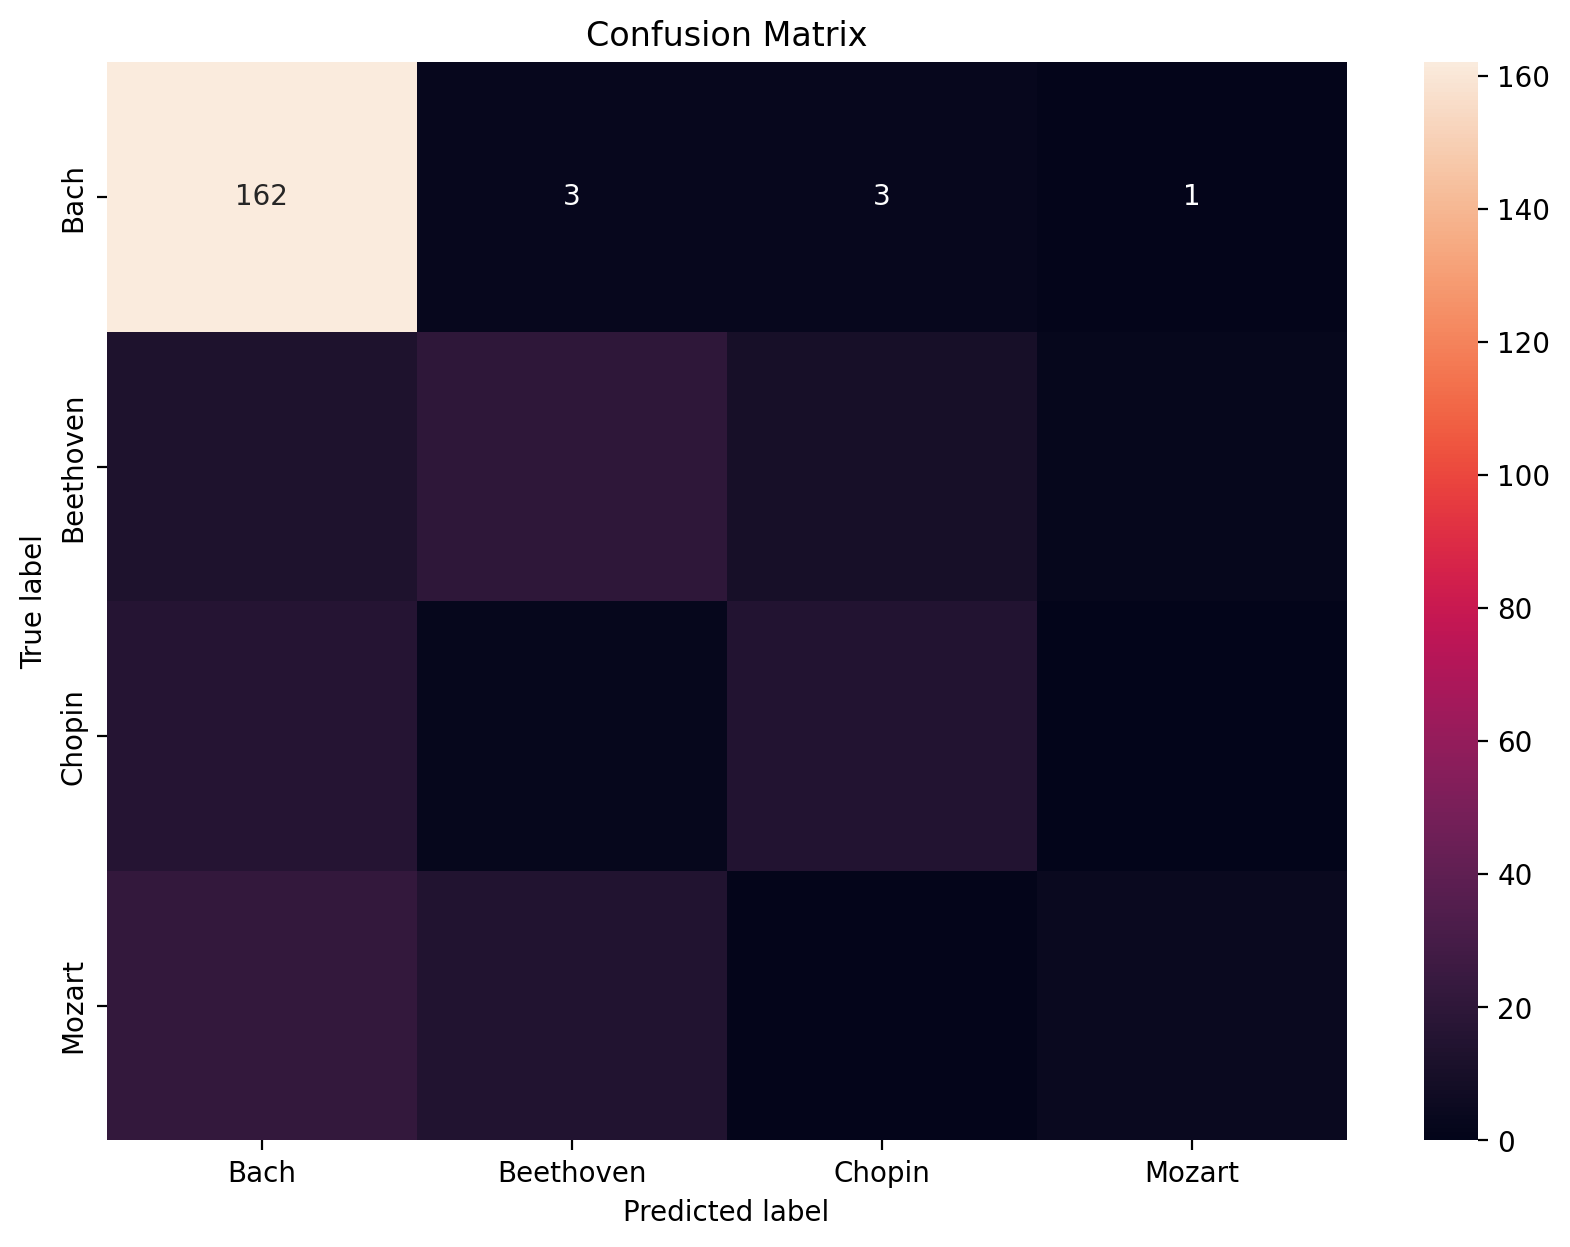

In [68]:
# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=df['composer'].unique()))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=df['composer'].unique(), yticklabels=df['composer'].unique())
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [69]:
# Accuracy, Precision and Recall
precision = precision_score(y_true_classes, y_pred_classes, average='macro')  # 'macro' averages over classes
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Precision: 0.59
Recall: 0.49
Accuracy: 0.70


# Model Optimization

In [73]:
def optimized_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# Assuming that the data preprocessing and splitting remains the same
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the optimized model
model = optimized_model((8, 1), y_train.shape[1])

# Setup callbacks for model optimization
checkpoint = ModelCheckpoint('best_optimized_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

callbacks_list = [checkpoint, early_stopping]

# Train the optimized model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks_list)

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 1.0940 - accuracy: 0.5936
Epoch 1: val_loss improved from inf to 1.04133, saving model to best_optimized_model.h5
18/18 [==============================] - 3s 43ms/step - loss: 1.0940 - accuracy: 0.5936 - val_loss: 1.0413 - val_accuracy: 0.5486
Epoch 2/50
10/18 [===============>..............] - ETA: 0s - loss: 0.9141 - accuracy: 0.6406
Epoch 2: val_loss improved from 1.04133 to 0.87455, saving model to best_optimized_model.h5


C:\Users\Nando\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 0s 11ms/step - loss: 0.9136 - accuracy: 0.6449 - val_loss: 0.8746 - val_accuracy: 0.6389
Epoch 3/50
10/18 [===============>..............] - ETA: 0s - loss: 0.8515 - accuracy: 0.6656
Epoch 3: val_loss improved from 0.87455 to 0.83413, saving model to best_optimized_model.h5
18/18 [==============================] - 0s 10ms/step - loss: 0.8315 - accuracy: 0.6745 - val_loss: 0.8341 - val_accuracy: 0.6632
Epoch 4/50
10/18 [===============>..............] - ETA: 0s - loss: 0.7649 - accuracy: 0.6656
Epoch 4: val_loss improved from 0.83413 to 0.79605, saving model to best_optimized_model.h5
18/18 [==============================] - 0s 9ms/step - loss: 0.7574 - accuracy: 0.6858 - val_loss: 0.7961 - val_accuracy: 0.6944
Epoch 5/50
10/18 [===============>..............] - ETA: 0s - loss: 0.7236 - accuracy: 0.7109
Epoch 5: val_loss improved from 0.79605 to 0.77257, saving model to best_optimized_model.h5
18/18 [==============================] - 0s 9ms/step 

9/9 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

        Bach       0.93      0.97      0.95       169
   Beethoven       0.61      0.69      0.65        45
      Chopin       0.59      0.58      0.58        33
      Mozart       0.72      0.51      0.60        41

    accuracy                           0.82       288
   macro avg       0.71      0.69      0.70       288
weighted avg       0.81      0.82      0.81       288



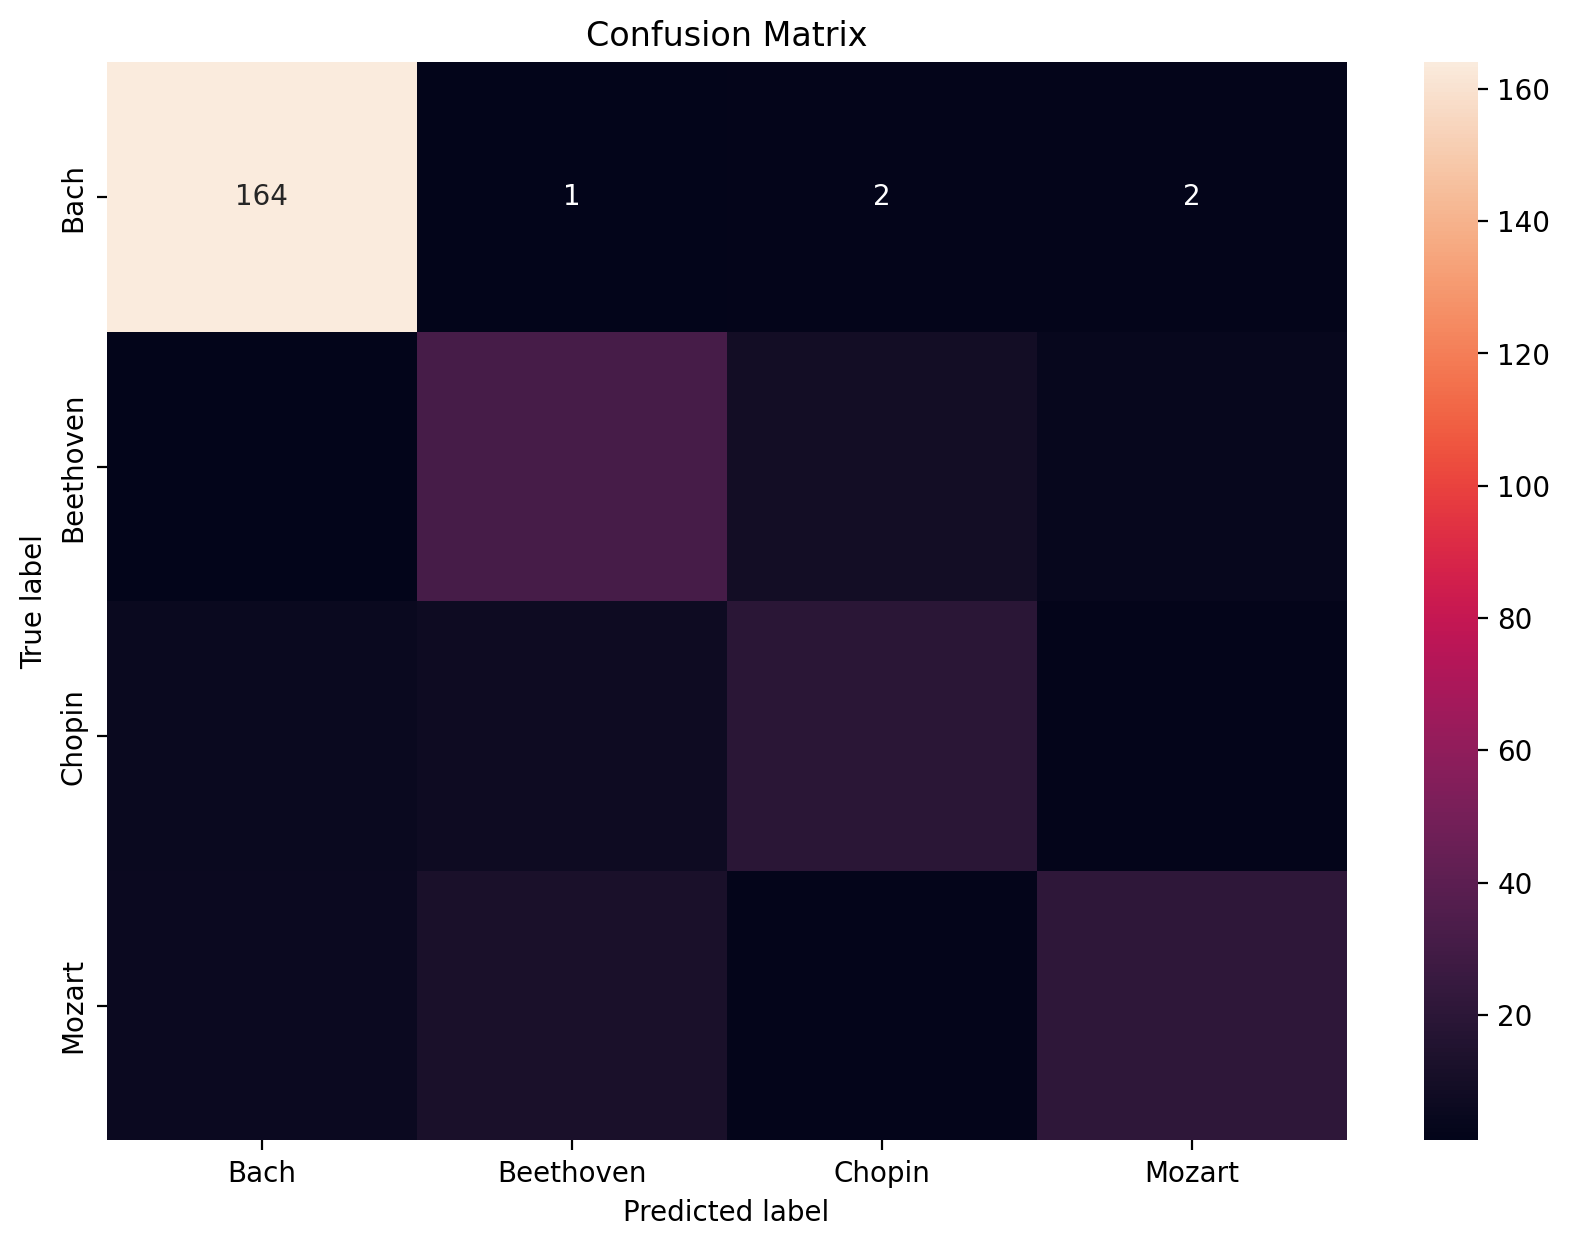

In [75]:
# Predict classes with the optimized model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate a classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=df['composer'].unique()))

# Display the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=df['composer'].unique(), yticklabels=df['composer'].unique())
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [76]:
# Calculate precision, recall, and accuracy
precision = precision_score(y_true_classes, y_pred_classes, average='macro')  # 'macro' averages over classes
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
accuracy = accuracy_score(y_true_classes, y_pred_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Precision: 0.71
Recall: 0.69
Accuracy: 0.82
